/kaggle/input/tensorflow-great-barrier-reef/train_images/video_0
Feature batch shape: torch.Size([1, 3, 720, 1280])
Labels batch shape: 1
('[]',)


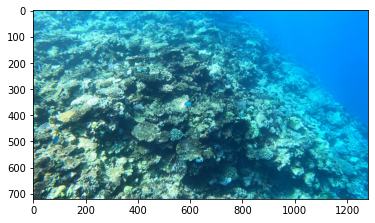

In [1]:
import numpy as np 
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt

# TODO: pewnie można zrobić zmienne globalne z directory path, żeby podmieniać na kagglową jak puszczamy w kagglu i na własną, jak puszczamy lokalnie
# *ewentualnie lokalnie ustawić jak w kaggle xd

class StarfishDataset(Dataset):
    def __init__(self, 
                 annotations_file='/kaggle/input/tensorflow-great-barrier-reef/train.csv', 
                 img_dir='/kaggle/input/tensorflow-great-barrier-reef/train_images/'
                ):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):

        print(os.path.join(self.img_dir, 'video_{}'.format(self.img_labels.iloc[idx][0], '{}.jpg'.format(self.img_labels.iloc[idx][2]))))
        image = read_image(os.path.join(self.img_dir, 'video_{}'.format(self.img_labels.iloc[idx][0]), '{}.jpg'.format(self.img_labels.iloc[idx][2])))
        label = self.img_labels.iloc[idx][-1]

        return image, label

dataset = StarfishDataset()
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
plt.imshow(train_features[0].permute(1, 2, 0))
print(train_labels)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session